![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Computer Vision - Lecture 2</a>


## Fine-Tuning with Pre-trained AlexNet 

In this notebook, we use a pre-trained [AlexNet](https://d2l.ai/chapter_convolutional-modern/alexnet.html) on the [MINC](http://opensurfaces.cs.cornell.edu/publications/minc/)  dataset. This notebook is similar to our previous notebook `MLA-CV-Lecture1-CNN.ipydb`, so we may skip some details to be concise. We will cover the following topics:

1. <a href="#1">Loading and Transforming Dataset</a>      
2. <a href="#2">Fine-tuning Pretrained AlexNet</a>
3. <a href="#3">Testing and Visualizations</a>


First, let's update mxnet (CUDA version) to at least to v1.7.0 and d2l to v0.17.0

In [1]:
! pip install -q -r ../requirements.txt

Now let's import the necessary libraries.

In [2]:
import os
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
import numpy as np

## 1. <a name="1">Loading and Transforming Dataset</a>
(<a href="#0">Go to top</a>)

To load the dataset properly, we need the massage the image data a bit by some `transforms` functions. Gluon provides a full list of [transforms functions](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html) to enable a wide variety of data augmentation. 

We will process some simple data transformations in this example. First, we load the image data and resize it to the given size (224,224). Next, we convert the image NDArray of shape (H x W x C) in the range [0, 255] to a float32 tensor NDArray of shape (C x H x W) in the range (0, 1) using the `ToTensor` class. Last, we normalize an tensor of shape (C x H x W) with its mean and standard deviation by `Normalize`.

In [3]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize()
])

Now apply the predefined transform functions and load the train, validation and test sets.

In practice, reading data can be a significant performance bottleneck, especially when our model is simple or when our computer is fast. To make our life easier when reading from the datasets, we use a `DataLoader` of Gluon, which reads a minibatch of data with size `batch_size` each time.

In [4]:
batch_size = 16

path = '../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

train_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True)

validation_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

test_loader = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False)

## 2. <a name="2">Fine-tuning Pretrained AlexNet</a>
(<a href="#0">Go to top</a>)

To fine-tune a pretrained model, we need the following 4 steps:
1. Define a neural network **finetune_net** with AlexNet architecture, with given number of output classes. Note that for `gluon.model_zoo.vision.alexnet` the default parameter `pretrained` is False, which means it will only return us an AlexNet architecture rather than an AlexNet architecture with the pretrained weights.

1. Initialize the **finetune_net** with [Xavier initialization](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#xavier-initialization) to make sure our random initialized weights are neither too small nor too huge.

1. Define another neural network, **pretrained_net**, and load the pretrained AlexNet model (which was trained on ImageNet) on it. Here, by specifying ``pretrained=True``, it will automatically download the model from GluonCV model zoo if necessary. For more pretrained models, please refer to [GluonCV Model Zoo](https://gluon-cv.mxnet.io/model_zoo/index.html).

1. Transfer the trained weights (except last layer) from **pretrained_net** to **finetune_net**, and output **finetune_net**.

In [5]:
def FineTuneAlexnet(classes, ctx):
    '''
    classes: number of the output classes 
    ctx: training context (CPU or GPU)
    '''
    finetune_net = gluon.model_zoo.vision.alexnet(classes=classes, pretrained=False, ctx=ctx)
    finetune_net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
    pretrained_net = gluon.model_zoo.vision.alexnet(pretrained=True, ctx=ctx)
    finetune_net.features = pretrained_net.features
    
    return finetune_net

Let's create a `net` using the `FineTuneAlexnet` on available GPUs (or CPUs) by defining the training context `ctx`. Since the MINC dataset has 6 categories, the output classes will be 6.

In [6]:
ctx = d2l.try_gpu() # Create neural net on CPU or GPU depending on your training instances
num_outputs = 6  # 6 output classes
net = FineTuneAlexnet(num_outputs, ctx)
net

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), Activation(relu))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (2): Conv2D(64 -> 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), Activation(relu))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): Conv2D(192 -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (5): Conv2D(384 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (6): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (8): Flatten
    (9): Dense(9216 -> 4096, Activation(relu))
    (10): Dropout(p = 0.5, axes

Next, we set up the hyperparameters for training, such as the learning rate of optimization algorithms. With the defined learning rate, we are able to create a `Trainer` to infer the neural network "how to optimize its weights".

In [7]:
learning_rate = 0.001
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate})

Besides, we need to specify the loss function. Since this problem is a multiclass classification task, we will use softmax as our loss funciton.

In [8]:
softmax_cross_etropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

Our network is almost ready to be finetuned! One last thing before the finetuning is to define the `accuracy` function for evulating our model.

In [9]:
def finetune_accuracy(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) == label.astype('float32')).mean()

Now it's the training time! Starting with the outer loop, we will have 10 epochs (10 full pass through our dataset). Within the inner loop, we yield each mini-batch from the `train_loader`, and update the weights based on the average statistics of this mini-batch.

In [10]:
epochs = 10

for epoch in range(epochs):
    
    train_loss, val_loss, train_acc, valid_acc = 0., 0., 0., 0.
    
    # Training loop: (with autograd and trainer steps, etc.)
    # This loop does the training of the neural network (weights are updated)
    for i, (data, label) in enumerate(train_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_etropy_loss(output, label)
        loss.backward()
        train_acc += finetune_accuracy(output, label)
        train_loss += loss.mean()
        trainer.step(data.shape[0])
    
    # Validation loop:
    # This loop tests the trained network on validation dataset
    # No weight updates here
    for i, (data, label) in enumerate(validation_loader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        valid_acc += finetune_accuracy(output, label)
        val_loss += softmax_cross_etropy_loss(output, label).mean()
        
    # Take averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f" % (
        epoch, train_loss.asnumpy()[0], train_acc.asnumpy()[0], val_loss.asnumpy()[0], valid_acc.asnumpy()[0]))

Epoch 0: train loss 1.457, train acc 0.482, val loss 0.758, val acc 0.771
Epoch 1: train loss 0.858, train acc 0.687, val loss 0.587, val acc 0.833
Epoch 2: train loss 0.660, train acc 0.767, val loss 0.511, val acc 0.854
Epoch 3: train loss 0.562, train acc 0.805, val loss 0.470, val acc 0.865
Epoch 4: train loss 0.497, train acc 0.828, val loss 0.439, val acc 0.865
Epoch 5: train loss 0.427, train acc 0.849, val loss 0.421, val acc 0.880
Epoch 6: train loss 0.361, train acc 0.877, val loss 0.452, val acc 0.875
Epoch 7: train loss 0.347, train acc 0.882, val loss 0.424, val acc 0.865
Epoch 8: train loss 0.351, train acc 0.878, val loss 0.433, val acc 0.875
Epoch 9: train loss 0.292, train acc 0.908, val loss 0.442, val acc 0.880


If you would like to save the trained model, no matter using it for inference or to retrain it later. You can call `save_parameters` function to save the model architecture and its weights.

In [11]:
net.save_parameters("my_model")

## 3. <a name="3">Testing and Visualizations</a>
(<a href="#0">Go to top</a>)

Let's validate our model predictions. Meanwhile, we use the `show_images` function and show the sample images and its prediction together.

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


[4. 0. 0. 3. 0. 3. 4. 3. 0. 0. 0. 0. 5. 5. 1. 2.]
<NDArray 16 @gpu(0)>


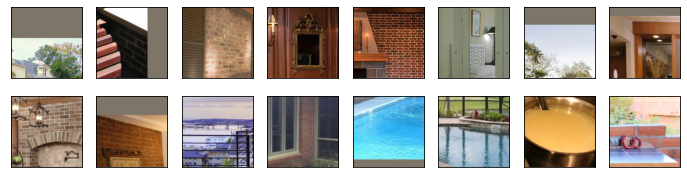

In [13]:
random_test_sample = gluon.data.DataLoader(gluon.data.vision.ImageFolderDataset(test_path),
                                    batch_size=2*8, shuffle=True)

for data, label in random_test_sample:
    show_images(data, 2, 8);
    data = data.as_in_context(ctx)
    pred = net(transform_test(data))
    print(pred.argmax(axis=1))
    break